In [9]:
%pylab inline
from operator import *
import numpy as np
# 区分测试集和训练集
from sklearn.cross_validation import train_test_split
# svm
from sklearn import svm
# knn
from sklearn.neighbors import KNeighborsClassifier
# 交叉验证
from sklearn.cross_validation import cross_val_score
# 画图
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
# payload
f_pl = open('src/payload.txt')
# keyword
f_key = open('src/key_list.txt')
# normal requrire
f_norm = open('src/normal_require.txt')
# f_norm = open('src/replace1.txt')

In [11]:
# 先把读进来的东西变成数组
pl_list = []
for line in f_pl.readlines():
    # 去掉最后的换行符
    line=line.strip('\n')
    pl_list.append(line)
key_list = []
for line in f_key.readlines():
    line=line.strip('\n')
    key_list.append(line)
norm_list = []
for line in f_norm.readlines():
    line=line.strip('\n')
    norm_list.append(line)

In [13]:
def changePayload(payload):
    p_list = []
    # 无关单词转化,key保留
#     for word.lower() in payload:
#         # 在key list中的敏感词
#         if word in key_list:
#             p_list.append(word)
#         # 非敏感词
#         elif ("normal_word" not in p_list):
#             p_list.append("normal_word")
#         else:
#             continue



    for word in key_list:
        if word in payload.lower():
            p_list.append(word)
        elif("normal_word" in payload):
            p_list.append("normal_word")
        else:
            continue
            
            

    # 特殊字符转化
    for i in payload:
        ascii = ord(i)
        if(ascii<48 or ascii>57 and ascii<65 or ascii>90 and ascii < 95 or ascii>95 and ascii<97 or ascii>122):
            if(('ascii'+ str(ascii)) not in p_list):
               p_list.append('ascii'+str(ascii))
            if(i != " "):
                payload = payload.replace(i," ")
    # 16进制转化
    payload = payload.split(" ")
    for word in payload:
        if(word[0:2] == "0x"):
            p_list.append("16hex")
            payload.remove(word)
    
    return p_list

In [14]:
# 创建文本训练集向量
def createDocVec(payloads,requires):
    vec = set([])
    for doc in payloads:
        vec = vec | set(doc)
    for doc in requires:
        vec = vec | set(doc)
    return list(vec)

In [15]:
# 函数：为每一个训练样本生成一个向量，词集模型
def wordToVec(vecList,doc):
    returnVec = [0] * len(vecList)
    for word in doc:
        # 如果
        if(word in vecList):
            returnVec[vecList.index(word)] = 1
        else:
            print("word is not contained:  " + word)
    return returnVec

In [16]:
# payload 和正常请求的数组转化
payloads = []
for pl in pl_list:
    payloads.append(changePayload(pl))
requires = []
for req in norm_list:
    requires.append(changePayload(req))
# payload和正常请求的向量转化
vec_list = createDocVec(payloads,requires)
payloads_vec = []
requires_vec = []
for payload in payloads:
    payloads_vec.append(wordToVec(vec_list,payload))
for require in requires:
    requires_vec.append(wordToVec(vec_list,require))
# payload 向量和普通请求向量
payloads_vec = np.array(payloads_vec)
requires_vec = np.array(requires_vec)


In [17]:
# 生成X
X = np.concatenate((payloads_vec,requires_vec))

In [18]:
# 生成Y
Y = []
for i in range(0,len(payloads_vec)):
    Y.append(1)
for i in range(0,len(requires_vec)):
    Y.append(0)

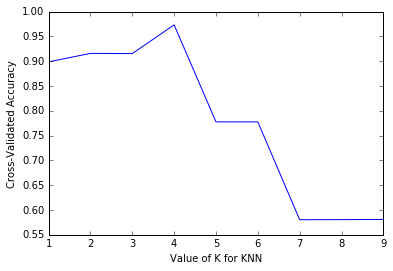

[0.89863945697869096, 0.91575798552481769, 0.91535496275250827, 0.973238422878825, 0.77768668503239158, 0.77768668503239158, 0.58040571826501997, 0.58060722965117473, 0.58100923847833119]


In [47]:
# knn here
# X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)
# # knn
knn = KNeighborsClassifier()
# # 训练
# knn.fit(X_train,Y_train)

k_range = range(1, 10)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
##    loss = -cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error') # for regression
    scores = cross_val_score(knn, X,Y, cv=10, scoring='accuracy') # for classification
    k_scores.append(scores.mean())
# print k_scores

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
print k_scores


In [19]:
# svm 交叉验证

# 设置算法
clf = svm.SVC(gamma=0.001)

# 用测试集预测 
scores = cross_val_score(clf, X,Y, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.8326791   0.99950932  1.          1.          1.          1.          1.
  1.          1.          1.        ]
0.983218842002


In [20]:
# 数据分割 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
# 设置算法
clf = svm.SVC(gamma=0.001)
# 训练
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
# 查看分类错了的样本
for i in range(len(X)):
    temp = np.array(X[i]).reshape((1,-1))
    if(clf.predict(temp)[0] != Y[i]):
        # 如果预测错误，打印出原文
        if i < len(pl_list):
            print "payload 分类错误"
            print pl_list[i]
        else:
            print "正常请求分类错误"
            print norm_list[(i-len(pl_list))]
        print "\n"
    

payload 分类错误
'=0#


payload 分类错误
'<1#


payload 分类错误
1'<99#


payload 分类错误
'=0=1#


payload 分类错误
'=0=1=1=1=1=1#


payload 分类错误
'!=2!=3!=4#


payload 分类错误
'|0#


payload 分类错误
'&0#


payload 分类错误
'^0#


payload 分类错误
'<<0#


payload 分类错误
'>>0#


payload 分类错误
'&''#


payload 分类错误
'%11&1#


payload 分类错误
'&1&1#


payload 分类错误
'|0&1#


payload 分类错误
'<<0|0#


payload 分类错误
'*9#


payload 分类错误
'/9#


payload 分类错误
'%9#


payload 分类错误
'+0#


payload 分类错误
'-0#


payload 分类错误
'+2+5-7#


payload 分类错误
'+0+0-0#


payload 分类错误
'-0-0-0-0-0#


payload 分类错误
'*9*8*7*6*5#


payload 分类错误
'/2/3/4#


payload 分类错误
'%12%34%56%78#


payload 分类错误
'/**/+/**/0#


payload 分类错误
'+++0+++++0*0#


payload 分类错误
admin' order by'


payload 分类错误
admin' group by'


payload 分类错误
'='


payload 分类错误
'<>'1


payload 分类错误
'>1='


payload 分类错误
'>1='


payload 分类错误
0'='0


payload 分类错误
0'='0


payload 分类错误
'=round(0,1)='1


payload 分类错误
'=round(0,1)='1


payload 分类错误
'*0*'


payload 分类错误
'*0*'


payload 分类错误
'+'


payload 分类错误
'+'




In [49]:
 np.array([1,0,1]).reshape((1, -1))

array([[1, 0, 1]])

In [ ]:
#扩充数据
#数据清洗
#分析分类失败的样本
#考虑贝叶斯分析融合进算法的可能性
#增加手工payload，用于测试

In [54]:
"sli" in "sli skadi asdkfi"
#     print word

True